## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import math
from math import sqrt
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import gridspec
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
plt.style.use('default')
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot

import pingouin as pg
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM, Flatten, Dropout


from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.optimizers import Adam



2023-09-01 03:30:32.323083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Multi-variate LSTM

    With satisfactory results, from LSTM in comparison with ARIMA, adn further motvation from our enriching literature review, we have in this study used the multi-variate LSTM in order to incorptare the different meterological variables, that were guided by our Feature Enginnering Step.

In [2]:
lstm_data = pd.read_csv('/Users/asur18/Desktop/MSc_Project_Data/My_Appoach/Data/LSTM.csv')

# Convert the 'Date' column to datetime
def convert_to_datetime(df):
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    except:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
    return df

lstm_data = convert_to_datetime(lstm_data)

In [3]:
lstm_data = lstm_data[['Date','Water Column','Water Temperature', 'degree_C Soil Temperature' , 'mS/cm Saturation Extract EC']]
lstm_data.set_index('Date',inplace=True)

# Scale the selected data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(lstm_data)

## Setting the random seeds for reproducibility and reshaping data for LSTM 

In [4]:
# Setting the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the lookback period
look_back = 5

# Reshape the data into sequences with a lookback period of 5
def create_sequences(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back):
        a = data[i:(i+look_back), :]
        X.append(a)
        Y.append(data[i+look_back, 0])  # Predict the next water level
    return np.array(X), np.array(Y)

X, y = create_sequences(scaled_data, look_back)

In [5]:
# Split the reshaped data into training and testing datasets
split_index = int(0.85 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Print the shape of the reshaped data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (83, 5, 4)
Shape of y_train: (83,)
Shape of X_test: (15, 5, 4)
Shape of y_test: (15,)


### Defining the performance metrics 

    - NSE (Nash Sutcliffe Efficiency)
    - RMSE(Root Mean Squared Error)
    - MAPE (Mean Absolute percentage Error)

In [6]:
def nash_sutcliffe_efficiency(observed, predicted):
    """
    Compute the Nash-Sutcliffe Efficiency.

    Parameters:
    - observed : list or array-like
        List or array of observed values
    - predicted : list or array-like
        List or array of predicted values

    Returns:
    - nse : float
        Nash-Sutcliffe Efficiency
    """
    observed_mean = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - observed_mean) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

In [7]:
import numpy as np

def mean_absolute_percentage_error(observed, predicted):
    """
    Compute the Mean Absolute Percentage Error.

    Parameters:
    - observed : list or array-like
        List or array of observed values
    - predicted : list or array-like
        List or array of predicted values

    Returns:
    - mape : float
        Mean Absolute Percentage Error
    """
    # Calculate the absolute percentage error for each data point
    absolute_percentage_error = np.abs((observed - predicted) / observed)

    # Calculate the mean of the absolute percentage errors
    mape = 100 * np.mean(absolute_percentage_error)

    return mape

## Developing the Model Archtitecture

In [8]:
import time

def run_loop(learning_rate, num_units, dropout_rate, batch_size, loop, num_epochs):
    for i in range(loop):
        
        # Start time capture
        start_time = time.time()
        
        # Define the LSTM model (Input Shape = lookback, number of features)
        model = Sequential()
        # Add the first LSTM layer
        model.add(LSTM(num_units, input_shape=(look_back, 4), kernel_initializer='glorot_uniform'))
        model.add(Dense(1, activation= 'relu', kernel_initializer='glorot_uniform'))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Train the model with validation data set to the test set
        history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=False, verbose=2, validation_data=(X_test, y_test))

        # Display the model summary
        model.summary()

        # Evaluate the model on the validation data
        validation_loss = model.evaluate(X_test, y_test)
        print(f"Validation Loss: {validation_loss}")

#         # Plot the training and validation loss
#         plt.figure(figsize=(12, 6))
#         plt.plot(history.history['loss'], label='Training Loss', color='black')
#         plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.legend()
#         plt.show()

        # Use the trained model to make predictions on the training and validation data
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)


        # Reshape the data to inverse transform
        train_pred_reshaped = np.zeros((len(train_pred), X_train.shape[2]))
        train_pred_reshaped[:,0] = train_pred[:,0].reshape(-1)
        test_pred_reshaped = np.zeros((len(test_pred), X_test.shape[2]))
        test_pred_reshaped[:,0] = test_pred[:,0].reshape(-1)

        # Inverse transform the predictions
        train_pred_original = scaler.inverse_transform(train_pred_reshaped)[:,0]
        test_pred_original = scaler.inverse_transform(test_pred_reshaped)[:,0]

        # Inverse transform the target values
        y_train_original = scaler.inverse_transform(np.hstack((y_train.reshape(-1,1), np.zeros((y_train.shape[0], X_train.shape[2]-1)))))[:,0]
        y_test_original = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((y_test.shape[0], X_test.shape[2]-1)))))[:,0]

        # Calculate the performance metrics
        mape_train = mean_absolute_percentage_error(y_train_original, train_pred_original)
        rmse_train = np.sqrt(mean_squared_error(y_train_original, train_pred_original))
        #r2_train = r2_score(y_train_original, train_pred_original)
        nse_train = nash_sutcliffe_efficiency(y_train_original, train_pred_original)

        mape_test = mean_absolute_percentage_error(y_test_original, test_pred_original)
        rmse_test = np.sqrt(mean_squared_error(y_test_original, test_pred_original))
        #r2_test = r2_score(y_test_original, test_pred_original)
        nse_test = nash_sutcliffe_efficiency(y_test_original, test_pred_original)
        
        # End time capture
        end_time = time.time()
        # Calculate elapsed time
        elapsed_time = end_time - start_time

        results.append((model, {"train_pred_original": train_pred_original, "test_pred_original": test_pred_original, "y_train_original": y_train_original, "y_test_original": y_test_original, "mape_train": mape_train, "rmse_train": rmse_train, "nse_train": nse_train, "mape_test": mape_test,"rmse_test": rmse_test,"nse_test": nse_test, "elapsed_time": elapsed_time}))         
        

## Executing the model with 100 Iteration

In [14]:
results = []
# run_loop(lr, num_units, dropout_rate, batch_size, loop, num_epochs):
run_loop(0.001, 50, 0.0, 16, 100, 40)

Epoch 1/40
6/6 - 2s - loss: 0.3985 - val_loss: 0.0061 - 2s/epoch - 309ms/step
Epoch 2/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 46ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 48ms/epoch - 8ms/step
Epoch 4/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 41ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 43ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 41ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 41ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 42ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 41ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 41ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 43ms/epoch - 7ms/step
Epoch 13/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 42ms

Epoch 2/40
6/6 - 0s - loss: 0.2716 - val_loss: 0.0354 - 46ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1036 - val_loss: 0.1011 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0289 - val_loss: 0.1710 - 39ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0260 - val_loss: 0.1812 - 39ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0220 - val_loss: 0.1416 - 40ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0132 - val_loss: 0.1047 - 40ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0149 - val_loss: 0.0861 - 38ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0172 - val_loss: 0.0811 - 39ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0154 - val_loss: 0.0819 - 38ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0128 - val_loss: 0.0812 - 39ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0113 - val_loss: 0.0755 - 39ms/epoch - 6ms/step
Epoch 13/40
6/6 - 0s - loss: 0.0105 - val_loss: 0.0668 - 39ms/epoch - 6ms/step
Epoch 14/40
6/6 - 0s - loss: 0.0102 - val_loss: 0.0585 - 40m

Epoch 4/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 40ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 37ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 37ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 37ms/epoch - 6ms/step
Epoch 13/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 14/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 15/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 16/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 3

Epoch 6/40
6/6 - 0s - loss: 0.0183 - val_loss: 0.0869 - 39ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0118 - val_loss: 0.0645 - 39ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0110 - val_loss: 0.0509 - 38ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0129 - val_loss: 0.0456 - 38ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0126 - val_loss: 0.0448 - 40ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0110 - val_loss: 0.0449 - 39ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0097 - val_loss: 0.0431 - 39ms/epoch - 6ms/step
Epoch 13/40
6/6 - 0s - loss: 0.0090 - val_loss: 0.0389 - 39ms/epoch - 6ms/step
Epoch 14/40
6/6 - 0s - loss: 0.0086 - val_loss: 0.0340 - 39ms/epoch - 6ms/step
Epoch 15/40
6/6 - 0s - loss: 0.0083 - val_loss: 0.0297 - 38ms/epoch - 6ms/step
Epoch 16/40
6/6 - 0s - loss: 0.0081 - val_loss: 0.0265 - 38ms/epoch - 6ms/step
Epoch 17/40
6/6 - 0s - loss: 0.0077 - val_loss: 0.0241 - 39ms/epoch - 6ms/step
Epoch 18/40
6/6 - 0s - loss: 0.0073 - val_loss: 0.0217 -

Epoch 7/40
6/6 - 0s - loss: 0.0257 - val_loss: 0.0951 - 40ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0214 - val_loss: 0.0734 - 38ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0223 - val_loss: 0.0626 - 39ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0223 - val_loss: 0.0589 - 41ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0203 - val_loss: 0.0582 - 39ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0180 - val_loss: 0.0568 - 39ms/epoch - 6ms/step
Epoch 13/40
6/6 - 0s - loss: 0.0162 - val_loss: 0.0531 - 38ms/epoch - 6ms/step
Epoch 14/40
6/6 - 0s - loss: 0.0149 - val_loss: 0.0476 - 39ms/epoch - 6ms/step
Epoch 15/40
6/6 - 0s - loss: 0.0139 - val_loss: 0.0420 - 39ms/epoch - 6ms/step
Epoch 16/40
6/6 - 0s - loss: 0.0131 - val_loss: 0.0372 - 39ms/epoch - 6ms/step
Epoch 17/40
6/6 - 0s - loss: 0.0123 - val_loss: 0.0335 - 39ms/epoch - 6ms/step
Epoch 18/40
6/6 - 0s - loss: 0.0114 - val_loss: 0.0304 - 38ms/epoch - 6ms/step
Epoch 19/40
6/6 - 0s - loss: 0.0106 - val_loss: 0.0276 

Epoch 9/40
6/6 - 0s - loss: 0.0204 - val_loss: 0.0751 - 39ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0184 - val_loss: 0.0737 - 40ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0164 - val_loss: 0.0703 - 39ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0149 - val_loss: 0.0642 - 38ms/epoch - 6ms/step
Epoch 13/40
6/6 - 0s - loss: 0.0139 - val_loss: 0.0571 - 38ms/epoch - 6ms/step
Epoch 14/40
6/6 - 0s - loss: 0.0131 - val_loss: 0.0508 - 39ms/epoch - 6ms/step
Epoch 15/40
6/6 - 0s - loss: 0.0124 - val_loss: 0.0458 - 39ms/epoch - 7ms/step
Epoch 16/40
6/6 - 0s - loss: 0.0116 - val_loss: 0.0417 - 38ms/epoch - 6ms/step
Epoch 17/40
6/6 - 0s - loss: 0.0108 - val_loss: 0.0378 - 39ms/epoch - 6ms/step
Epoch 18/40
6/6 - 0s - loss: 0.0101 - val_loss: 0.0340 - 39ms/epoch - 6ms/step
Epoch 19/40
6/6 - 0s - loss: 0.0095 - val_loss: 0.0303 - 38ms/epoch - 6ms/step
Epoch 20/40
6/6 - 0s - loss: 0.0090 - val_loss: 0.0271 - 38ms/epoch - 6ms/step
Epoch 21/40
6/6 - 0s - loss: 0.0085 - val_loss: 0.024

Epoch 11/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 40ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 13/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 7ms/step
Epoch 14/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 15/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 37ms/epoch - 6ms/step
Epoch 16/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 7ms/step
Epoch 17/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 18/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 19/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 20/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 21/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 22/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 23/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.00

Epoch 13/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 40ms/epoch - 7ms/step
Epoch 14/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 40ms/epoch - 7ms/step
Epoch 15/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 40ms/epoch - 7ms/step
Epoch 16/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 17/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 7ms/step
Epoch 18/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 7ms/step
Epoch 19/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 20/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 21/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 22/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 23/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 24/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 25/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.00

Epoch 15/40
6/6 - 0s - loss: 0.0076 - val_loss: 0.0136 - 40ms/epoch - 7ms/step
Epoch 16/40
6/6 - 0s - loss: 0.0072 - val_loss: 0.0121 - 41ms/epoch - 7ms/step
Epoch 17/40
6/6 - 0s - loss: 0.0070 - val_loss: 0.0107 - 40ms/epoch - 7ms/step
Epoch 18/40
6/6 - 0s - loss: 0.0067 - val_loss: 0.0095 - 40ms/epoch - 7ms/step
Epoch 19/40
6/6 - 0s - loss: 0.0065 - val_loss: 0.0086 - 39ms/epoch - 6ms/step
Epoch 20/40
6/6 - 0s - loss: 0.0062 - val_loss: 0.0077 - 39ms/epoch - 7ms/step
Epoch 21/40
6/6 - 0s - loss: 0.0060 - val_loss: 0.0069 - 38ms/epoch - 6ms/step
Epoch 22/40
6/6 - 0s - loss: 0.0058 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 23/40
6/6 - 0s - loss: 0.0057 - val_loss: 0.0054 - 38ms/epoch - 6ms/step
Epoch 24/40
6/6 - 0s - loss: 0.0055 - val_loss: 0.0048 - 38ms/epoch - 6ms/step
Epoch 25/40
6/6 - 0s - loss: 0.0054 - val_loss: 0.0043 - 39ms/epoch - 7ms/step
Epoch 26/40
6/6 - 0s - loss: 0.0052 - val_loss: 0.0038 - 38ms/epoch - 6ms/step
Epoch 27/40
6/6 - 0s - loss: 0.0051 - val_loss: 0.00

Epoch 16/40
6/6 - 0s - loss: 0.0074 - val_loss: 0.0303 - 40ms/epoch - 7ms/step
Epoch 17/40
6/6 - 0s - loss: 0.0070 - val_loss: 0.0262 - 39ms/epoch - 6ms/step
Epoch 18/40
6/6 - 0s - loss: 0.0066 - val_loss: 0.0224 - 39ms/epoch - 6ms/step
Epoch 19/40
6/6 - 0s - loss: 0.0063 - val_loss: 0.0189 - 38ms/epoch - 6ms/step
Epoch 20/40
6/6 - 0s - loss: 0.0061 - val_loss: 0.0160 - 45ms/epoch - 7ms/step
Epoch 21/40
6/6 - 0s - loss: 0.0059 - val_loss: 0.0135 - 37ms/epoch - 6ms/step
Epoch 22/40
6/6 - 0s - loss: 0.0058 - val_loss: 0.0116 - 39ms/epoch - 6ms/step
Epoch 23/40
6/6 - 0s - loss: 0.0056 - val_loss: 0.0099 - 37ms/epoch - 6ms/step
Epoch 24/40
6/6 - 0s - loss: 0.0055 - val_loss: 0.0085 - 38ms/epoch - 6ms/step
Epoch 25/40
6/6 - 0s - loss: 0.0053 - val_loss: 0.0073 - 38ms/epoch - 6ms/step
Epoch 26/40
6/6 - 0s - loss: 0.0052 - val_loss: 0.0063 - 38ms/epoch - 6ms/step
Epoch 27/40
6/6 - 0s - loss: 0.0051 - val_loss: 0.0055 - 38ms/epoch - 6ms/step
Epoch 28/40
6/6 - 0s - loss: 0.0049 - val_loss: 0.00

6/6 - 0s - loss: 0.0073 - val_loss: 0.0317 - 40ms/epoch - 7ms/step
Epoch 18/40
6/6 - 0s - loss: 0.0065 - val_loss: 0.0268 - 38ms/epoch - 6ms/step
Epoch 19/40
6/6 - 0s - loss: 0.0060 - val_loss: 0.0223 - 38ms/epoch - 6ms/step
Epoch 20/40
6/6 - 0s - loss: 0.0057 - val_loss: 0.0185 - 39ms/epoch - 6ms/step
Epoch 21/40
6/6 - 0s - loss: 0.0055 - val_loss: 0.0155 - 37ms/epoch - 6ms/step
Epoch 22/40
6/6 - 0s - loss: 0.0053 - val_loss: 0.0132 - 39ms/epoch - 7ms/step
Epoch 23/40
6/6 - 0s - loss: 0.0051 - val_loss: 0.0114 - 39ms/epoch - 6ms/step
Epoch 24/40
6/6 - 0s - loss: 0.0050 - val_loss: 0.0099 - 38ms/epoch - 6ms/step
Epoch 25/40
6/6 - 0s - loss: 0.0049 - val_loss: 0.0087 - 38ms/epoch - 6ms/step
Epoch 26/40
6/6 - 0s - loss: 0.0048 - val_loss: 0.0077 - 38ms/epoch - 6ms/step
Epoch 27/40
6/6 - 0s - loss: 0.0047 - val_loss: 0.0070 - 39ms/epoch - 7ms/step
Epoch 28/40
6/6 - 0s - loss: 0.0046 - val_loss: 0.0063 - 39ms/epoch - 6ms/step
Epoch 29/40
6/6 - 0s - loss: 0.0046 - val_loss: 0.0057 - 39ms/ep

Epoch 19/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 40ms/epoch - 7ms/step
Epoch 20/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 21/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 22/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 40ms/epoch - 7ms/step
Epoch 23/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 24/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 37ms/epoch - 6ms/step
Epoch 25/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 26/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 27/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 28/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 39ms/epoch - 6ms/step
Epoch 29/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 30/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0061 - 38ms/epoch - 6ms/step
Epoch 31/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.00

Epoch 21/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 39ms/epoch - 7ms/step
Epoch 22/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 41ms/epoch - 7ms/step
Epoch 23/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 37ms/epoch - 6ms/step
Epoch 24/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 39ms/epoch - 6ms/step
Epoch 25/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 38ms/epoch - 6ms/step
Epoch 26/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 37ms/epoch - 6ms/step
Epoch 27/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 36ms/epoch - 6ms/step
Epoch 28/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 38ms/epoch - 6ms/step
Epoch 29/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 38ms/epoch - 6ms/step
Epoch 30/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 39ms/epoch - 6ms/step
Epoch 31/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 38ms/epoch - 6ms/step
Epoch 32/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.0059 - 38ms/epoch - 6ms/step
Epoch 33/40
6/6 - 0s - loss: 0.3985 - val_loss: 0.00

Epoch 23/40
6/6 - 0s - loss: 0.0058 - val_loss: 0.0072 - 40ms/epoch - 7ms/step
Epoch 24/40
6/6 - 0s - loss: 0.0056 - val_loss: 0.0063 - 39ms/epoch - 6ms/step
Epoch 25/40
6/6 - 0s - loss: 0.0054 - val_loss: 0.0056 - 40ms/epoch - 7ms/step
Epoch 26/40
6/6 - 0s - loss: 0.0053 - val_loss: 0.0049 - 39ms/epoch - 7ms/step
Epoch 27/40
6/6 - 0s - loss: 0.0051 - val_loss: 0.0043 - 39ms/epoch - 7ms/step
Epoch 28/40
6/6 - 0s - loss: 0.0050 - val_loss: 0.0038 - 37ms/epoch - 6ms/step
Epoch 29/40
6/6 - 0s - loss: 0.0049 - val_loss: 0.0033 - 39ms/epoch - 6ms/step
Epoch 30/40
6/6 - 0s - loss: 0.0048 - val_loss: 0.0029 - 39ms/epoch - 6ms/step
Epoch 31/40
6/6 - 0s - loss: 0.0047 - val_loss: 0.0026 - 37ms/epoch - 6ms/step
Epoch 32/40
6/6 - 0s - loss: 0.0046 - val_loss: 0.0022 - 39ms/epoch - 6ms/step
Epoch 33/40
6/6 - 0s - loss: 0.0045 - val_loss: 0.0020 - 38ms/epoch - 6ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0044 - val_loss: 0.0017 - 39ms/epoch - 6ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0044 - val_loss: 0.00

Epoch 24/40
6/6 - 0s - loss: 0.0057 - val_loss: 0.0046 - 39ms/epoch - 7ms/step
Epoch 25/40
6/6 - 0s - loss: 0.0055 - val_loss: 0.0040 - 39ms/epoch - 6ms/step
Epoch 26/40
6/6 - 0s - loss: 0.0053 - val_loss: 0.0035 - 41ms/epoch - 7ms/step
Epoch 27/40
6/6 - 0s - loss: 0.0052 - val_loss: 0.0030 - 39ms/epoch - 7ms/step
Epoch 28/40
6/6 - 0s - loss: 0.0050 - val_loss: 0.0027 - 39ms/epoch - 6ms/step
Epoch 29/40
6/6 - 0s - loss: 0.0049 - val_loss: 0.0023 - 39ms/epoch - 7ms/step
Epoch 30/40
6/6 - 0s - loss: 0.0047 - val_loss: 0.0020 - 38ms/epoch - 6ms/step
Epoch 31/40
6/6 - 0s - loss: 0.0046 - val_loss: 0.0018 - 38ms/epoch - 6ms/step
Epoch 32/40
6/6 - 0s - loss: 0.0045 - val_loss: 0.0016 - 38ms/epoch - 6ms/step
Epoch 33/40
6/6 - 0s - loss: 0.0044 - val_loss: 0.0014 - 38ms/epoch - 6ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0043 - val_loss: 0.0013 - 39ms/epoch - 6ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0043 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0042 - val_loss: 0.00

In [16]:
#print(results)

best_index = 0
best_score = results[0][1]['nse_test']
for i in range(len(results)):
    if (results[i][1]['nse_test'] > best_score):
        best_score = results[i][1]['nse_test']
        best_index = i

In [17]:
# Get the best model metrics
best_metrics = results[best_index][1]
best_time = best_metrics['elapsed_time']

print(f"Best Model Index: {best_index}")
print(f"Convergence Time: {best_time:.4f} seconds")


print(f"Training MAPE: {best_metrics['mape_train']:.4f}")
print(f"Training RMSE: {best_metrics['rmse_train']:.4f}")
print(f"Training NSE: {best_metrics['nse_train']:.4f}")
print('\n')
print(f"Testing MAPE: {best_metrics['mape_test']:.4f}")
print(f"Testing RMSE: {best_metrics['rmse_test']:.4f}")
print(f"Testing NSE: {best_metrics['nse_test']:.4f}")


Best Model Index: 16
Convergence Time: 4.0095 seconds
Training MAPE: 0.4445
Training RMSE: 0.0872
Training NSE: 0.9240


Testing MAPE: 0.1937
Testing RMSE: 0.0389
Testing NSE: 0.4508


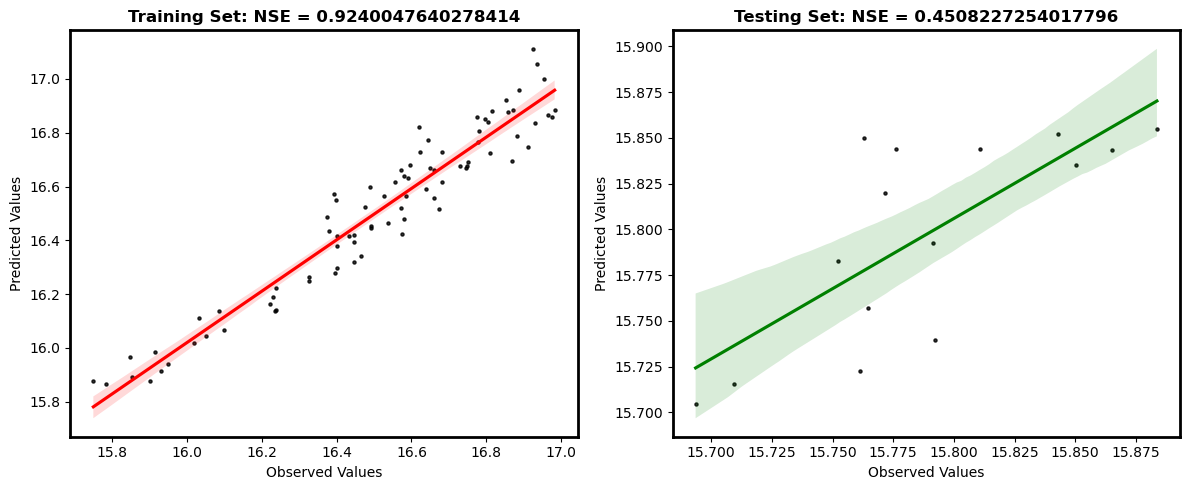

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Plot the observed vs. predicted values for the training set
plt.subplot(1, 2, 1)
sns.regplot(x=results[best_index][1]['y_train_original'], y=results[best_index][1]['train_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'red'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_train']
plt.title(f'Training Set: NSE = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Plot the observed vs. predicted values for the testing set
plt.subplot(1, 2, 2)
sns.regplot(x=results[best_index][1]['y_test_original'], y=results[best_index][1]['test_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'green'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_test']
plt.title(f'Testing Set: NSE = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
#plt.savefig("01_Multi-LSTM_fit_diagram.png", dpi=300)
plt.show()


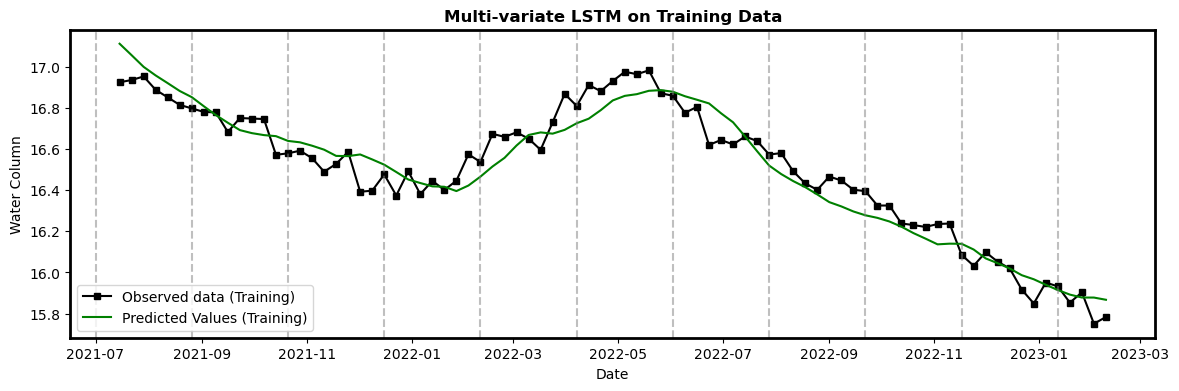

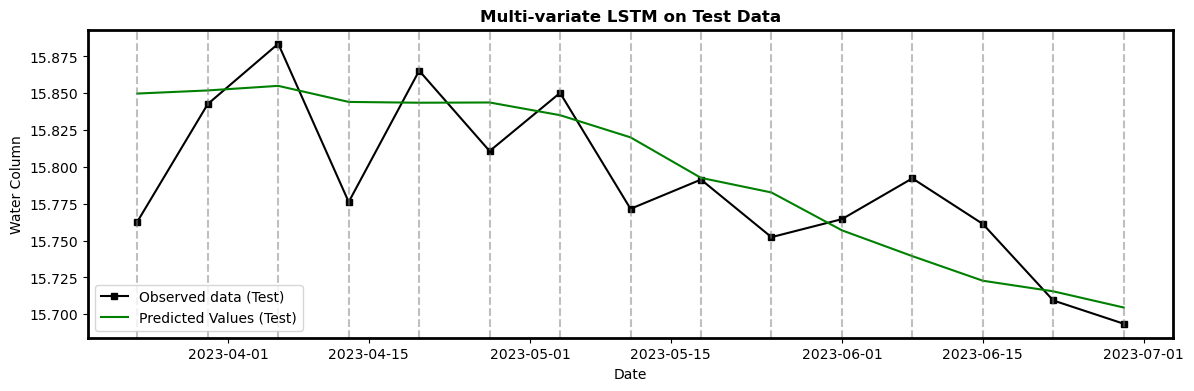

In [19]:
# First Plot for Training Data
plt.figure(figsize=(14, 4))

# Plot the predicted values for the training set
plt.plot(lstm_data.index[:split_index], results[best_index][1]['y_train_original'], label='Observed data (Training)', marker='s', markersize =4, color= 'black')

# Plot the predicted values for the training set
plt.plot(lstm_data.index[:split_index], results[best_index][1]['train_pred_original'], label='Predicted Values (Training)', color='green', linestyle='solid')

# Add vertical lines for each 8 weeks
current_date = pd.Timestamp('2021-07-01')
end_date = lstm_data.index[split_index]
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=8)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel('Date')
plt.ylabel('Water Column')
plt.title('Multi-variate LSTM on Training Data', fontweight='bold')
plt.legend(loc='lower left')
plt.savefig("02_Multi-LSTM_forecast_diagram.png", dpi=300)

plt.show()

# Second Plot for Test Data
plt.figure(figsize=(14, 4))

# Plot the predicted values for the testing set
plt.plot(lstm_data.index[split_index+look_back:], results[best_index][1]['y_test_original'], label='Observed data (Test)', marker='s', markersize =4, color= 'black')

# Plot the predicted values for the testing set
plt.plot(lstm_data.index[split_index+look_back:], results[best_index][1]['test_pred_original'], label='Predicted Values (Test)', color='g', linestyle='solid')

# Add vertical lines for each 8 weeks
current_date = lstm_data.index[split_index+look_back]
end_date = pd.Timestamp('2023-07-01')
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=1)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel('Date')
plt.ylabel('Water Column')
plt.title('Multi-variate LSTM on Test Data', fontweight='bold')
plt.legend(loc='lower left')
#plt.savefig("03_Multi-LSTM_forecast_diagram.png", dpi=300)
plt.show()


# ....




## Fine Tuning Model

### With Dropoout Regularization

In [20]:
lstm_data = pd.read_csv('/Users/asur18/Desktop/MSc_Project_Data/My_Appoach/Data/LSTM.csv')

# Convert the 'Date' column to datetime
def convert_to_datetime(df):
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    except:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
    return df

lstm_data = convert_to_datetime(lstm_data)

In [21]:
lstm_data = lstm_data[['Date','Water Column','Water Temperature', 'degree_C Soil Temperature' , 'mS/cm Saturation Extract EC']]
lstm_data.set_index('Date',inplace=True)

# Scale the selected data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(lstm_data)

In [22]:
# Setting the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the lookback period
look_back = 5

# Reshape the data into sequences with a lookback period of 5
def create_sequences(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back):
        a = data[i:(i+look_back), :]
        X.append(a)
        Y.append(data[i+look_back, 0])  # Predict the next water level
    return np.array(X), np.array(Y)

X, y = create_sequences(scaled_data, look_back)

In [23]:
# Split the reshaped data into training and testing datasets
split_index = int(0.85 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Print the shape of the reshaped data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (83, 5, 4)
Shape of y_train: (83,)
Shape of X_test: (15, 5, 4)
Shape of y_test: (15,)


In [24]:
import time

def run_loop(learning_rate, num_units, dropout_rate, batch_size, loop, num_epochs):
    for i in range(loop):
        
        # Start time capture
        start_time = time.time()
        
        # Define the LSTM model
        model = Sequential()
        # Define the LSTM model (Input Shape = lookback, number of features)
        model.add(LSTM(num_units, input_shape=(look_back, 4), kernel_initializer='glorot_uniform'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation= 'relu', kernel_initializer='glorot_uniform'))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Train the model with validation data set to the test set
        history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=False, verbose=2, validation_data=(X_test, y_test))

        # Display the model summary
        model.summary()

        # Evaluate the model on the validation data
        validation_loss = model.evaluate(X_test, y_test)
        print(f"Validation Loss: {validation_loss}")

        # Use the trained model to make predictions on the training and validation data
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)


        # Reshape the data to inverse transform
        train_pred_reshaped = np.zeros((len(train_pred), X_train.shape[2]))
        train_pred_reshaped[:,0] = train_pred[:,0].reshape(-1)
        test_pred_reshaped = np.zeros((len(test_pred), X_test.shape[2]))
        test_pred_reshaped[:,0] = test_pred[:,0].reshape(-1)

        # Inversing the prediction value to orginal scale
        train_pred_original = scaler.inverse_transform(train_pred_reshaped)[:,0]
        test_pred_original = scaler.inverse_transform(test_pred_reshaped)[:,0]

        # Inverse transform the target values(observed data)
        y_train_original = scaler.inverse_transform(np.hstack((y_train.reshape(-1,1), np.zeros((y_train.shape[0], X_train.shape[2]-1)))))[:,0]
        y_test_original = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((y_test.shape[0], X_test.shape[2]-1)))))[:,0]

        # Calculate the performance metrics
        mape_train = mean_absolute_percentage_error(y_train_original, train_pred_original)
        rmse_train = np.sqrt(mean_squared_error(y_train_original, train_pred_original))
        nse_train = nash_sutcliffe_efficiency(y_train_original, train_pred_original)

        mape_test = mean_absolute_percentage_error(y_test_original, test_pred_original)
        rmse_test = np.sqrt(mean_squared_error(y_test_original, test_pred_original))
        nse_test = nash_sutcliffe_efficiency(y_test_original, test_pred_original)
        
        # End time capture
        end_time = time.time()
        # Calculate elapsed time
        elapsed_time = end_time - start_time

        results.append((model, {"train_pred_original": train_pred_original, "test_pred_original": test_pred_original, "y_train_original": y_train_original, "y_test_original": y_test_original, "mape_train": mape_train, "rmse_train": rmse_train, "nse_train": nse_train, "mape_test": mape_test,"rmse_test": rmse_test,"nse_test": nse_test, "elapsed_time": elapsed_time}))         
        

## Executing the model with 100 Iteration

In [25]:
results = []
# run_loop(lr, num_units, dropout_rate, batch_size, loop, num_epochs):
run_loop(0.001, 50, 0.5, 16, 100, 40)

Epoch 1/40
6/6 - 2s - loss: 0.3618 - val_loss: 0.0035 - 2s/epoch - 310ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1874 - val_loss: 0.0074 - 45ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0689 - val_loss: 0.0341 - 48ms/epoch - 8ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0370 - val_loss: 0.0576 - 48ms/epoch - 8ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0363 - val_loss: 0.0553 - 42ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0289 - val_loss: 0.0435 - 41ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0274 - val_loss: 0.0324 - 42ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0185 - val_loss: 0.0255 - 41ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0210 - val_loss: 0.0227 - 39ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0321 - val_loss: 0.0239 - 41ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0257 - val_loss: 0.0262 - 41ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0237 - val_loss: 0.0251 - 41ms/epoch - 7ms/step
Epoch 13/40
6/6 - 0s - loss: 0.0268 - val_loss: 0.0233 - 42ms

1/1 [==============================] - 0s 21ms/step - loss: 0.0030
Validation Loss: 0.0029592588543891907
1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.2876 - val_loss: 0.0039 - 2s/epoch - 293ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1398 - val_loss: 0.0035 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0321 - val_loss: 0.0190 - 41ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0249 - val_loss: 0.0301 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0423 - val_loss: 0.0268 - 38ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0279 - val_loss: 0.0202 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0265 - val_loss: 0.0152 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0284 - val_loss: 0.0136 - 36ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0196 - val_loss: 0.0130 - 37ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0252 - val_loss: 0.0140 - 37ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0197 - val_loss: 0.0154 - 37ms

Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step - loss: 8.3562e-04
Validation Loss: 0.0008356242324225605
1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.2188 - val_loss: 0.0057 - 2s/epoch - 293ms/step
Epoch 2/40
6/6 - 0s - loss: 0.0868 - val_loss: 0.0273 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0383 - val_loss: 0.0502 - 41ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0395 - val_loss: 0.0516 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0443 - val_loss: 0.0391 - 36ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0258 - val_loss: 0.0277 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0229 - val_loss: 0.0223 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0307 - val_loss: 0.0208 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0255 - val_loss: 0.0195 - 37ms/epoch - 6ms/step


                                                                 
 dense_65 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 22ms/step - loss: 0.0011
Validation Loss: 0.0010731888469308615
1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.2152 - val_loss: 0.0049 - 2s/epoch - 292ms/step
Epoch 2/40
6/6 - 0s - loss: 0.0726 - val_loss: 0.0274 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0309 - val_loss: 0.0520 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0329 - val_loss: 0.0531 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0345 - val_loss: 0.0420 - 38ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0293 - val_loss: 0.0336 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0253 - val

                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_67 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 24ms/step - loss: 0.0011
Validation Loss: 0.0011475072242319584
1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3626 - val_loss: 0.0111 - 2s/epoch - 292ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2484 - val_loss: 0.0505 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1118 - val_loss: 0.1174 - 43ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0521 - val_loss: 0.1756 - 39ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0495 - val_loss: 0.1775 - 38ms/epo

 lstm_69 (LSTM)              (None, 50)                11000     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_69 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 23ms/step - loss: 9.4496e-04
Validation Loss: 0.0009449552744626999
1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.2149 - val_loss: 0.0302 - 2s/epoch - 290ms/step
Epoch 2/40
6/6 - 0s - loss: 0.0963 - val_loss: 0.0751 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0486 - val_loss: 0.1168 - 43ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0332 - val_loss: 0.1287 - 39ms/epoch - 7ms

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_71 (LSTM)              (None, 50)                11000     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_71 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 22ms/step - loss: 0.0029
Validation Loss: 0.0029210527427494526
1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3856 - val_loss: 0.0028 - 2s/epoch - 293ms/step
Epoch 2/40
6/6 - 0s - loss: 0.3007 - val_loss: 0.0132 - 43ms/epoch - 7ms/step

Epoch 39/40
6/6 - 0s - loss: 0.0147 - val_loss: 0.0028 - 40ms/epoch - 7ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0084 - val_loss: 0.0020 - 40ms/epoch - 7ms/step
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 50)                11000     
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_73 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 22ms/step - loss: 0.0020
Validation Loss: 0.0019871185068041086
1/1 [==============================] - 0s 20ms/st

Epoch 37/40
6/6 - 0s - loss: 0.0139 - val_loss: 0.0022 - 41ms/epoch - 7ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0114 - val_loss: 0.0023 - 40ms/epoch - 7ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0106 - val_loss: 0.0015 - 40ms/epoch - 7ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0076 - val_loss: 0.0010 - 37ms/epoch - 6ms/step
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 50)                11000     
                                                                 
 dropout_15 (Dropout)        (None, 50)                0         
                                                                 
 dense_75 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_______________________________________________________________

Epoch 35/40
6/6 - 0s - loss: 0.0104 - val_loss: 0.0016 - 38ms/epoch - 6ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0117 - val_loss: 0.0012 - 37ms/epoch - 6ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0157 - val_loss: 0.0015 - 38ms/epoch - 6ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0133 - val_loss: 0.0014 - 39ms/epoch - 6ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0132 - val_loss: 0.0011 - 38ms/epoch - 6ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0092 - val_loss: 8.8392e-04 - 36ms/epoch - 6ms/step
Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 50)                11000     
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_77 (Dense)            (None, 1)                 51        
                                     

Epoch 33/40
6/6 - 0s - loss: 0.0127 - val_loss: 0.0035 - 41ms/epoch - 7ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0125 - val_loss: 0.0023 - 39ms/epoch - 7ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0111 - val_loss: 0.0017 - 39ms/epoch - 7ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0135 - val_loss: 0.0017 - 38ms/epoch - 6ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0120 - val_loss: 0.0026 - 40ms/epoch - 7ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0113 - val_loss: 0.0026 - 38ms/epoch - 6ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0121 - val_loss: 0.0015 - 39ms/epoch - 6ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0080 - val_loss: 0.0013 - 38ms/epoch - 6ms/step
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_79 (LSTM)              (None, 50)                11000     
                                                                 
 dropout_19 (Dropout)        (None, 50)                0         
               

Epoch 31/40
6/6 - 0s - loss: 0.0204 - val_loss: 0.0100 - 42ms/epoch - 7ms/step
Epoch 32/40
6/6 - 0s - loss: 0.0177 - val_loss: 0.0112 - 41ms/epoch - 7ms/step
Epoch 33/40
6/6 - 0s - loss: 0.0175 - val_loss: 0.0103 - 42ms/epoch - 7ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0188 - val_loss: 0.0077 - 41ms/epoch - 7ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0127 - val_loss: 0.0058 - 39ms/epoch - 7ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0161 - val_loss: 0.0042 - 42ms/epoch - 7ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0167 - val_loss: 0.0056 - 39ms/epoch - 6ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0131 - val_loss: 0.0076 - 42ms/epoch - 7ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0159 - val_loss: 0.0061 - 40ms/epoch - 7ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0105 - val_loss: 0.0037 - 41ms/epoch - 7ms/step
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 50)                

Epoch 29/40
6/6 - 0s - loss: 0.0146 - val_loss: 0.0047 - 40ms/epoch - 7ms/step
Epoch 30/40
6/6 - 0s - loss: 0.0169 - val_loss: 0.0029 - 40ms/epoch - 7ms/step
Epoch 31/40
6/6 - 0s - loss: 0.0202 - val_loss: 0.0042 - 39ms/epoch - 7ms/step
Epoch 32/40
6/6 - 0s - loss: 0.0225 - val_loss: 0.0045 - 38ms/epoch - 6ms/step
Epoch 33/40
6/6 - 0s - loss: 0.0138 - val_loss: 0.0055 - 39ms/epoch - 6ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0176 - val_loss: 0.0027 - 38ms/epoch - 6ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0115 - val_loss: 0.0018 - 39ms/epoch - 6ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0129 - val_loss: 0.0023 - 38ms/epoch - 6ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0133 - val_loss: 0.0022 - 39ms/epoch - 7ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0141 - val_loss: 0.0021 - 40ms/epoch - 7ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0117 - val_loss: 0.0018 - 39ms/epoch - 6ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0102 - val_loss: 0.0013 - 38ms/epoch - 6ms/step
Model: "sequential_83"
_____________________________

Epoch 27/40
6/6 - 0s - loss: 0.0100 - val_loss: 0.0029 - 43ms/epoch - 7ms/step
Epoch 28/40
6/6 - 0s - loss: 0.0123 - val_loss: 0.0032 - 41ms/epoch - 7ms/step
Epoch 29/40
6/6 - 0s - loss: 0.0131 - val_loss: 0.0022 - 43ms/epoch - 7ms/step
Epoch 30/40
6/6 - 0s - loss: 0.0109 - val_loss: 0.0013 - 40ms/epoch - 7ms/step
Epoch 31/40
6/6 - 0s - loss: 0.0173 - val_loss: 0.0017 - 42ms/epoch - 7ms/step
Epoch 32/40
6/6 - 0s - loss: 0.0143 - val_loss: 0.0018 - 39ms/epoch - 6ms/step
Epoch 33/40
6/6 - 0s - loss: 0.0101 - val_loss: 0.0012 - 41ms/epoch - 7ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0130 - val_loss: 8.4065e-04 - 40ms/epoch - 7ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0141 - val_loss: 9.2486e-04 - 41ms/epoch - 7ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0116 - val_loss: 9.2048e-04 - 38ms/epoch - 6ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0146 - val_loss: 0.0010 - 42ms/epoch - 7ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0104 - val_loss: 0.0011 - 41ms/epoch - 7ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0112 - va

Epoch 25/40
6/6 - 0s - loss: 0.0169 - val_loss: 0.0171 - 42ms/epoch - 7ms/step
Epoch 26/40
6/6 - 0s - loss: 0.0153 - val_loss: 0.0138 - 39ms/epoch - 7ms/step
Epoch 27/40
6/6 - 0s - loss: 0.0170 - val_loss: 0.0132 - 40ms/epoch - 7ms/step
Epoch 28/40
6/6 - 0s - loss: 0.0219 - val_loss: 0.0148 - 39ms/epoch - 7ms/step
Epoch 29/40
6/6 - 0s - loss: 0.0138 - val_loss: 0.0135 - 40ms/epoch - 7ms/step
Epoch 30/40
6/6 - 0s - loss: 0.0154 - val_loss: 0.0105 - 38ms/epoch - 6ms/step
Epoch 31/40
6/6 - 0s - loss: 0.0155 - val_loss: 0.0111 - 39ms/epoch - 7ms/step
Epoch 32/40
6/6 - 0s - loss: 0.0167 - val_loss: 0.0109 - 39ms/epoch - 6ms/step
Epoch 33/40
6/6 - 0s - loss: 0.0134 - val_loss: 0.0108 - 54ms/epoch - 9ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0175 - val_loss: 0.0086 - 69ms/epoch - 11ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0127 - val_loss: 0.0062 - 42ms/epoch - 7ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0152 - val_loss: 0.0060 - 41ms/epoch - 7ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0140 - val_loss: 0.0

Epoch 23/40
6/6 - 0s - loss: 0.0177 - val_loss: 0.0177 - 40ms/epoch - 7ms/step
Epoch 24/40
6/6 - 0s - loss: 0.0230 - val_loss: 0.0152 - 41ms/epoch - 7ms/step
Epoch 25/40
6/6 - 0s - loss: 0.0182 - val_loss: 0.0135 - 39ms/epoch - 7ms/step
Epoch 26/40
6/6 - 0s - loss: 0.0181 - val_loss: 0.0098 - 43ms/epoch - 7ms/step
Epoch 27/40
6/6 - 0s - loss: 0.0169 - val_loss: 0.0101 - 42ms/epoch - 7ms/step
Epoch 28/40
6/6 - 0s - loss: 0.0181 - val_loss: 0.0133 - 39ms/epoch - 7ms/step
Epoch 29/40
6/6 - 0s - loss: 0.0194 - val_loss: 0.0110 - 39ms/epoch - 6ms/step
Epoch 30/40
6/6 - 0s - loss: 0.0156 - val_loss: 0.0080 - 38ms/epoch - 6ms/step
Epoch 31/40
6/6 - 0s - loss: 0.0165 - val_loss: 0.0090 - 39ms/epoch - 6ms/step
Epoch 32/40
6/6 - 0s - loss: 0.0195 - val_loss: 0.0094 - 39ms/epoch - 7ms/step
Epoch 33/40
6/6 - 0s - loss: 0.0135 - val_loss: 0.0089 - 39ms/epoch - 7ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0187 - val_loss: 0.0073 - 38ms/epoch - 6ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0119 - val_loss: 0.00

In [26]:
#print(results)

best_index = 0
best_score = results[0][1]['nse_test']
for i in range(len(results)):
    if (results[i][1]['nse_test'] > best_score):
        best_score = results[i][1]['nse_test']
        best_index = i

In [27]:
# Get the best model metrics
best_metrics = results[best_index][1]
best_time = best_metrics['elapsed_time']

print(f"Best Model Index: {best_index}")
print(f"Convergence Time: {best_time:.4f} seconds")


print(f"Training MAPE: {best_metrics['mape_train']:.4f}")
print(f"Training RMSE: {best_metrics['rmse_train']:.4f}")
print(f"Training NSE: {best_metrics['nse_train']:.4f}")
print('\n')
print(f"Testing MAPE: {best_metrics['mape_test']:.4f}")
print(f"Testing RMSE: {best_metrics['rmse_test']:.4f}")
print(f"Testing NSE: {best_metrics['nse_test']:.4f}")


Best Model Index: 14
Convergence Time: 4.0385 seconds
Training MAPE: 0.5205
Training RMSE: 0.1043
Training NSE: 0.8912


Testing MAPE: 0.1938
Testing RMSE: 0.0366
Testing NSE: 0.5117


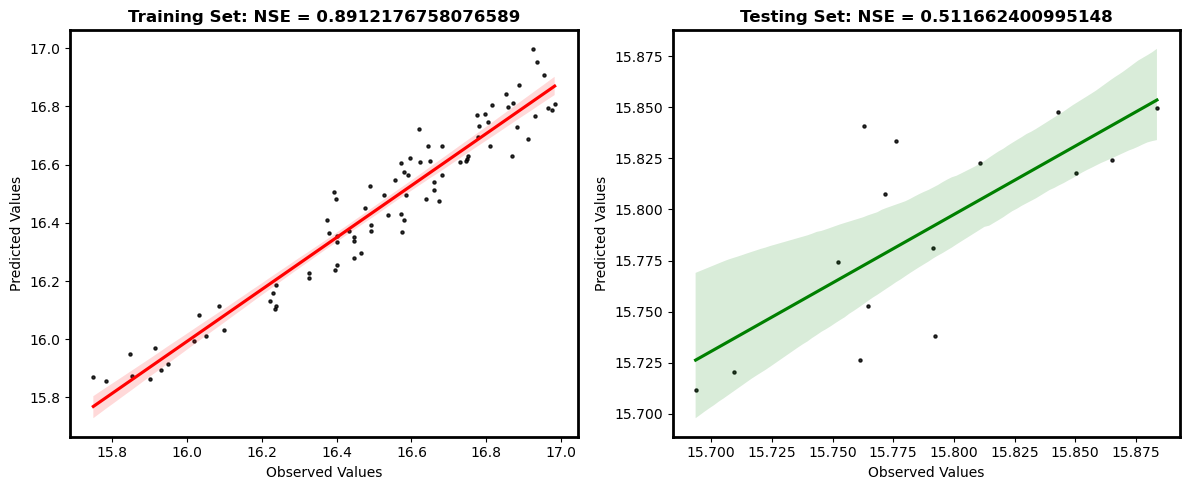

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Plot the observed vs. predicted values for the training set
plt.subplot(1, 2, 1)
sns.regplot(x=results[best_index][1]['y_train_original'], y=results[best_index][1]['train_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'red'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_train']
plt.title(f'Training Set: NSE = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Plot the observed vs. predicted values for the testing set
plt.subplot(1, 2, 2)
sns.regplot(x=results[best_index][1]['y_test_original'], y=results[best_index][1]['test_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'green'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_test']
plt.title(f'Testing Set: NSE = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
#plt.savefig("01_Multi-LSTM_fit_diagram.png", dpi=300)
plt.show()


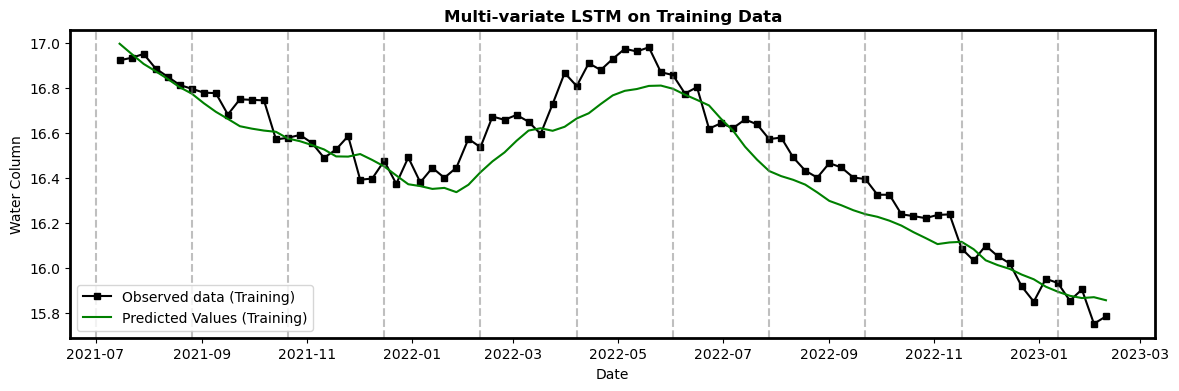

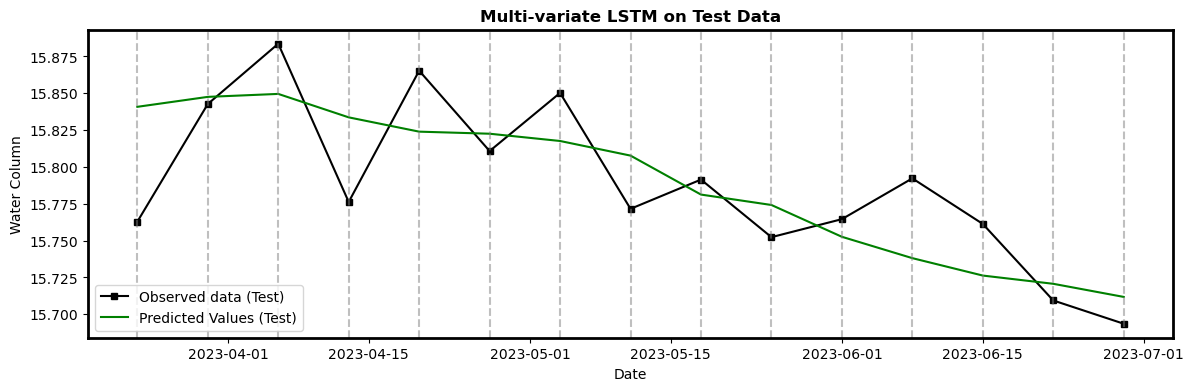

In [29]:
# First Plot for Training Data
plt.figure(figsize=(14, 4))

# Plot the predicted values for the training set
plt.plot(lstm_data.index[:split_index], results[best_index][1]['y_train_original'], label='Observed data (Training)', marker='s', markersize =4, color= 'black')

# Plot the predicted values for the training set
plt.plot(lstm_data.index[:split_index], results[best_index][1]['train_pred_original'], label='Predicted Values (Training)', color='green', linestyle='solid')

# Add vertical lines for each 8 weeks
current_date = pd.Timestamp('2021-07-01')
end_date = lstm_data.index[split_index]
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=8)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel('Date')
plt.ylabel('Water Column')
plt.title('Multi-variate LSTM on Training Data', fontweight='bold')
plt.legend(loc='lower left')
plt.savefig("02_Multi-LSTM_forecast_diagram.png", dpi=300)

plt.show()

# Second Plot for Test Data
plt.figure(figsize=(14, 4))

# Plot the predicted values for the testing set
plt.plot(lstm_data.index[split_index+look_back:], results[best_index][1]['y_test_original'], label='Observed data (Test)', marker='s', markersize =4, color= 'black')

# Plot the predicted values for the testing set
plt.plot(lstm_data.index[split_index+look_back:], results[best_index][1]['test_pred_original'], label='Predicted Values (Test)', color='g', linestyle='solid')

# Add vertical lines for each 8 weeks
current_date = lstm_data.index[split_index+look_back]
end_date = pd.Timestamp('2023-07-01')
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=1)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel('Date')
plt.ylabel('Water Column')
plt.title('Multi-variate LSTM on Test Data', fontweight='bold')
plt.legend(loc='lower left')
plt.savefig("03_Multi-LSTM_forecast_diagram.png", dpi=300)
plt.show()
